In [1]:
# Capstone Objective – Module 20

# This module performs exploratory data analysis (EDA) on daily coffee vending machine transaction data to uncover purchasing patterns and demand cycles. The goal is to identify key sales drivers and build a baseline machine learning model to predict daily revenue.

# Primary modeling target for this module:
# Daily total revenue

# This baseline model will serve as a comparison for more advanced forecasting models in Module 24.

In [16]:
import pandas as pd
import numpy as np
%matplotlib inline

In [5]:
df = pd.read_csv(r"C:\Users\anrad\OneDrive\Documents\ML AI\Coffe_sales.csv")

In [6]:
df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
hour_of_day    3547 non-null int64
cash_type      3547 non-null object
money          3547 non-null float64
coffee_name    3547 non-null object
Time_of_Day    3547 non-null object
Weekday        3547 non-null object
Month_name     3547 non-null object
Weekdaysort    3547 non-null int64
Monthsort      3547 non-null int64
Date           3547 non-null object
Time           3547 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
hour_of_day    3547 non-null int64
cash_type      3547 non-null object
money          3547 non-null float64
coffee_name    3547 non-null object
Time_of_Day    3547 non-null object
Weekday        3547 non-null object
Month_name     3547 non-null object
Weekdaysort    3547 non-null int64
Monthsort      3547 non-null int64
Date           3547 non-null datetime64[ns]
Time           3547 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 304.9+ KB


In [12]:
df['Date'].min(), df['Date'].max()

(Timestamp('2024-03-01 00:00:00'), Timestamp('2025-03-23 00:00:00'))

In [13]:
daily = df.groupby('Date').agg({
    'money': 'sum',
    'coffee_name': 'count'
}).rename(columns={
    'money': 'daily_revenue',
    'coffee_name': 'daily_transactions'
}).reset_index()

In [14]:
daily.head()
daily.shape
daily.describe()

,daily_revenue,daily_transactions
count,381.000000,381.000000
mean,294.607822,9.309711
std,163.167893,5.217747
min,23.020000,1.000000
25%,172.420000,5.000000
50%,272.360000,8.000000
75%,380.620000,12.000000
max,836.660000,26.000000


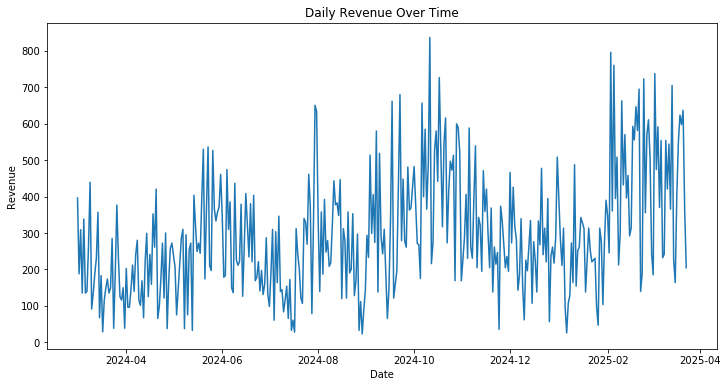

In [17]:
# Daily Revenue

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily['Date'], daily['daily_revenue'])
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


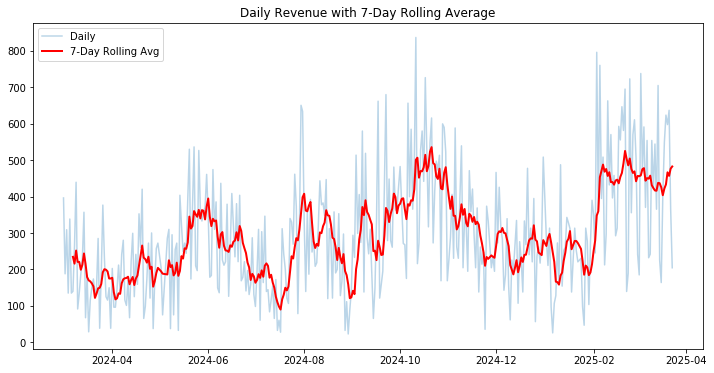

In [18]:
#7 Day Rolling Avg

daily['rolling_7'] = daily['daily_revenue'].rolling(7).mean()

plt.figure(figsize=(12,6))
plt.plot(daily['Date'], daily['daily_revenue'], alpha=0.3, label='Daily')
plt.plot(daily['Date'], daily['rolling_7'], color='red', linewidth=2, label='7-Day Rolling Avg')
plt.legend()
plt.title("Daily Revenue with 7-Day Rolling Average")
plt.show()

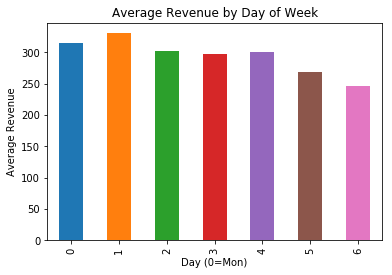

Average revenue is significantly higher during weekdays, peaking on Tuesday, and lowest on Sunday. The approximately 25–30% swing between peak and trough days suggests strong commuter-driven demand and clear weekly seasonality. Day-of-week should be included as a key predictive feature in forecasting models.


In [21]:
#seasonality

daily['day_of_week'] = daily['Date'].dt.dayofweek

daily.groupby('day_of_week')['daily_revenue'].mean().plot(kind='bar')
plt.title("Average Revenue by Day of Week")
plt.xlabel("Day (0=Mon)")
plt.ylabel("Average Revenue")
plt.show()
print("Average revenue is significantly higher during weekdays, peaking on Tuesday, and lowest on Sunday. The approximately 25–30% swing between peak and trough days suggests strong commuter-driven demand and clear weekly seasonality. Day-of-week should be included as a key predictive feature in forecasting models.")

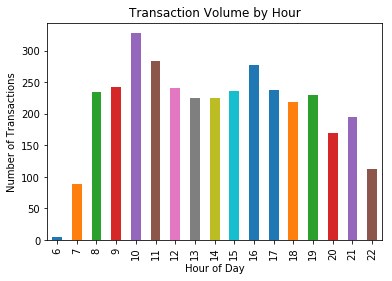

Transaction volume peaks between 9–11 AM, with 10 AM being the highest hour. Demand declines steadily after 7 PM, indicating strong commuter-driven purchasing behavior. These patterns suggest inventory and product assortment should prioritize morning demand.


In [23]:
#Hourly Demand Pattern (Transaction-Level)

df.groupby('hour_of_day')['money'].count().plot(kind='bar')
plt.title("Transaction Volume by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()
print("Transaction volume peaks between 9–11 AM, with 10 AM being the highest hour. Demand declines steadily after 7 PM, indicating strong commuter-driven purchasing behavior. These patterns suggest inventory and product assortment should prioritize morning demand.")

In [27]:
#Top Products by Phase 

morning = df[df['hour_of_day'].between(8,11)]
afternoon = df[df['hour_of_day'].between(12,17)]

print("Morning Top Products")
print(morning['coffee_name'].value_counts().head())

print("\nAfternoon Top Products")
print(afternoon['coffee_name'].value_counts().head())
print("Morning demand is dominated by Americano-based drinks, suggesting functional, commuter-driven consumption. In contrast, afternoon demand shifts toward milk-based beverages such as lattes and cappuccinos, with specialty drinks like hot chocolate appearing more frequently. This indicates time-of-day behavioral segmentation in product preference.")

Morning Top Products
Americano with Milk    311
Americano              205
Latte                  185
Cortado                141
Cappuccino             101
Name: coffee_name, dtype: int64

Afternoon Top Products
Latte                  320
Americano with Milk    290
Americano              268
Cappuccino             198
Hot Chocolate          107
Name: coffee_name, dtype: int64
Morning demand is dominated by Americano-based drinks, suggesting functional, commuter-driven consumption. In contrast, afternoon demand shifts toward milk-based beverages such as lattes and cappuccinos, with specialty drinks like hot chocolate appearing more frequently. This indicates time-of-day behavioral segmentation in product preference.


In [31]:
#Daily Revenue Model
daily = df.groupby('Date').agg({
    'money': 'sum',
    'coffee_name': 'count'
}).rename(columns={
    'money': 'daily_revenue',
    'coffee_name': 'daily_transactions'
}).reset_index()

daily = daily.copy()  
daily['lag_1'] = daily['daily_revenue'].shift(1)
daily['lag_7'] = daily['daily_revenue'].shift(7)
daily['rolling_7'] = daily['daily_revenue'].rolling(7).mean()

daily = daily.dropna()

In [32]:
daily.shape

(374, 6)

In [34]:
#Daily Revenue Model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

daily['day_of_week'] = daily['Date'].dt.dayofweek
daily['month'] = daily['Date'].dt.month
daily['is_weekend'] = daily['day_of_week'] >= 5


# Target
y = daily['daily_revenue']

# Features
X = daily[['day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_7', 'rolling_7']]


In [35]:
#Daily Revenue Model Training Split

split_idx = int(len(daily) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [36]:
#Daily Revenue Model - Train Baseline Model

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)


In [37]:
#Daily Revenue Model Error Rate

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2:  {r2:.3f}")

MAE:  127.25
RMSE: 157.17
R^2:  0.326


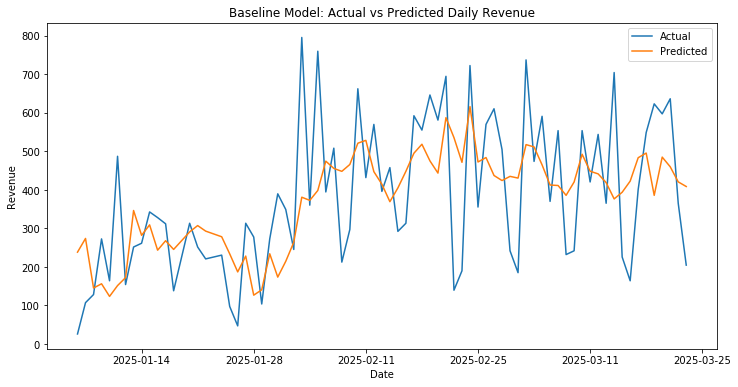

In [38]:
#Daily Revenue Model Overview

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily['Date'].iloc[split_idx:], y_test.values, label='Actual')
plt.plot(daily['Date'].iloc[split_idx:], pred, label='Predicted')
plt.title("Baseline Model: Actual vs Predicted Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

rolling_7      0.588180
lag_1          0.149427
lag_7          0.138588
day_of_week    0.062979
month          0.052279
is_weekend     0.008547
dtype: float64


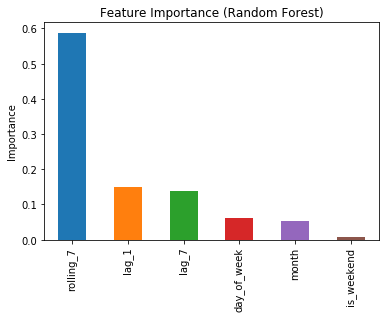

The model relies primarily on recent historical revenue (rolling 7-day average), indicating strong autoregressive structure in the data. Calendar-based features such as day of week and month contribute less incremental predictive value once recent sales behavior is included. This suggests that demand patterns are highly persistent and cyclical.


In [40]:
# Daily Revenue Model Feature Importance (Top Drivers)
import pandas as pd

fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(fi)

fi.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()
print("The model relies primarily on recent historical revenue (rolling 7-day average), indicating strong autoregressive structure in the data. Calendar-based features such as day of week and month contribute less incremental predictive value once recent sales behavior is included. This suggests that demand patterns are highly persistent and cyclical.")